# Data Build Notebook

Script downloads RGB band NAIP images clipped to the grid cells from Firebreak. Images are saved in folder directory named after the Firebreak class label. 

* USDA NAIP Image service url: https://gis.apfo.usda.gov/arcgis/rest/services/NAIP/USDA_CONUS_PRIME/ImageServer


In [1]:
import geopandas as gpd
import requests
import pandas as pd

In [2]:
zipSHP = r'D:\Projects\WORKING\ML\vectors\Training_Labels\Training_Labels_06_2023\Training_Labels_06_2023.zip'
gpRead = gpd.read_file(zipSHP)

In [3]:
gpRead.head()

,STATE,BREAK_NAME,ID,geometry
0,Arizona,Scattered Residential,0,"POLYGON ((-110.70460 34.92963, -110.70926 34.9..."
1,Arizona,Scattered Residential,1,"POLYGON ((-112.12995 35.44619, -112.13460 35.4..."
2,Arizona,Scattered Residential,2,"POLYGON ((-111.80854 33.69949, -111.81320 33.6..."
3,Arizona,Scattered Residential,3,"POLYGON ((-112.12529 35.65721, -112.12995 35.6..."
4,Arizona,Scattered Residential,4,"POLYGON ((-114.27728 32.69048, -114.28194 32.6..."


In [4]:
#gdfQuery = gpRead[gpRead['BREAK_NAME'].isin(['Wildland','Water','Agriculture','Scattered Residential','Low Density Residential','Medium Density Residential','High Density Residential','Urban','Urban Non-Residential'])]
gdfQuery = gpRead[gpRead['BREAK_NAME']=='Wildland']

len(gdfQuery)

1180

<Axes: >

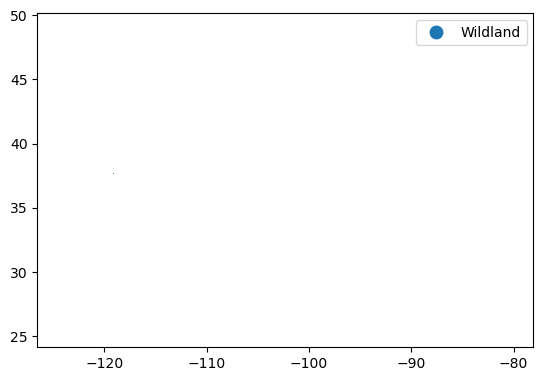

In [5]:
gdfQuery.plot('BREAK_NAME',legend=True)

In [6]:
gdfQuery.head()

,STATE,BREAK_NAME,ID,geometry
600,Arizona,Wildland,600,"POLYGON ((-112.21845 32.03740, -112.22311 32.0..."
601,Arizona,Wildland,601,"POLYGON ((-110.22948 36.10531, -110.23414 36.1..."
602,Arizona,Wildland,602,"POLYGON ((-111.79923 31.84172, -111.80389 31.8..."
603,Arizona,Wildland,603,"POLYGON ((-110.50430 31.89143, -110.50896 31.8..."
604,Arizona,Wildland,604,"POLYGON ((-112.73549 35.24262, -112.74014 35.2..."


### Create Data Frame

Geopandas creates a new data frame for the queried classes and adds a field for BBOX bounds. The bounds are calculated and populated in the new geometry field. 

In [7]:
gdf = gpd.GeoDataFrame(gdfQuery, geometry='geometry')

gdf['bounds'] = gdf['geometry'].apply(lambda x: x.bounds)


In [8]:
gdf.head()

,STATE,BREAK_NAME,ID,geometry,bounds
600,Arizona,Wildland,600,"POLYGON ((-112.21845 32.03740, -112.22311 32.0...","(-112.22310599999997, 32.03739900000005, -112...."
601,Arizona,Wildland,601,"POLYGON ((-110.22948 36.10531, -110.23414 36.1...","(-110.23413999999997, 36.10530600000004, -110...."
602,Arizona,Wildland,602,"POLYGON ((-111.79923 31.84172, -111.80389 31.8...","(-111.80388599999998, 31.84172200000006, -111...."
603,Arizona,Wildland,603,"POLYGON ((-110.50430 31.89143, -110.50896 31.8...","(-110.50896199999994, 31.89143100000007, -110...."
604,Arizona,Wildland,604,"POLYGON ((-112.73549 35.24262, -112.74014 35.2...","(-112.74014399999999, 35.242616000000055, -112..."


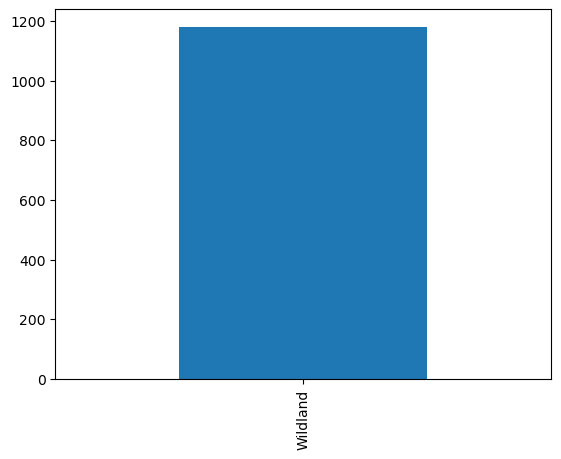

In [9]:
gdf['BREAK_NAME'].describe()
f = gdf['BREAK_NAME'].value_counts()
ax = f.plot.bar()

## Create Label Directories

Need to make a folder directory for all the label class names. JPEG tiles will be saved here according to the Firebreak class.

In [10]:
import os
save_dir = r'D:\Projects\WORKING\ML\imagery\training_data'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for label_name in gdf['BREAK_NAME'].str.lower().str.replace(' ','_').str.replace('-','_').unique():
    print(label_name)
    if not os.path.exists(os.path.join(save_dir,label_name)):
        os.makedirs(os.path.join(save_dir,label_name))

wildland


In [16]:
gdf['file_save'] = gdf.apply(lambda row: os.path.join(save_dir + '/',row['BREAK_NAME'].lower().replace(' ','_').replace('-','_') + '/' + str(row['ID'])+'.jpg'),axis=1)

In [20]:
#print(gdf['file_save'][75])
gdf['file_save']


600      D:\Projects\WORKING\ML\imagery\training_data/w...
601      D:\Projects\WORKING\ML\imagery\training_data/w...
602      D:\Projects\WORKING\ML\imagery\training_data/w...
603      D:\Projects\WORKING\ML\imagery\training_data/w...
604      D:\Projects\WORKING\ML\imagery\training_data/w...
                               ...                        
10055    D:\Projects\WORKING\ML\imagery\training_data/w...
10056    D:\Projects\WORKING\ML\imagery\training_data/w...
10057    D:\Projects\WORKING\ML\imagery\training_data/w...
10058    D:\Projects\WORKING\ML\imagery\training_data/w...
10059    D:\Projects\WORKING\ML\imagery\training_data/w...
Name: file_save, Length: 1180, dtype: object

In [21]:
def get_save_url(x):
    url = """https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX={}&CRS=EPSG:4326&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/jpeg&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE"""
    #print(url.format(','.join([str(val) for val in [x[1],x[0],x[3],x[2]]])))
    return url.format(','.join([str(val) for val in [x[1],x[0],x[3],x[2]]]))


In [22]:
gdf['url'] = gdf['bounds'].apply(get_save_url)

In [24]:
print(gdf['url'][600])
gdf['url']

https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=32.03739900000005,-112.22310599999997,32.040719000000024,-112.21844799999997&CRS=EPSG:4326&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/jpeg&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE


600      https://gis.apfo.usda.gov/arcgis/services/NAIP...
601      https://gis.apfo.usda.gov/arcgis/services/NAIP...
602      https://gis.apfo.usda.gov/arcgis/services/NAIP...
603      https://gis.apfo.usda.gov/arcgis/services/NAIP...
604      https://gis.apfo.usda.gov/arcgis/services/NAIP...
                               ...                        
10055    https://gis.apfo.usda.gov/arcgis/services/NAIP...
10056    https://gis.apfo.usda.gov/arcgis/services/NAIP...
10057    https://gis.apfo.usda.gov/arcgis/services/NAIP...
10058    https://gis.apfo.usda.gov/arcgis/services/NAIP...
10059    https://gis.apfo.usda.gov/arcgis/services/NAIP...
Name: url, Length: 1180, dtype: object

## Image Download

A function will be called to download and save the JPEG images to the corresponding Firebreak class folders. Sometimes the JPEG images do not download properly. When images fail to download they are either all black or cannot be opened. Check to make sure images are downloading properly at first by downloading one class at a time. Also, the number of URL requests at a time can cause the script to crash. Change the `time.sleep()` function to adjust the time between url requests. A 3 second delay is the current setting, but a longer delay will make sure images always download properly with out a timeout error.


In [16]:
def save_data(url,path):
    res = requests.get(url)
    with open(path,'wb') as f:
        f.write(res.content)
    return res.status_code


url_list = gdf['url'].tolist()
save_list = gdf['file_save'].tolist()

#print(url_list)
#print(save_list)

In [87]:
from joblib import Parallel,delayed
import time

#status_codes = Parallel(n_jobs=10,backend='threading')(delayed(save_data)(url=url,path=path) for url,path in zip(url_list,save_list))
#status_codes = Parallel(n_jobs=10,backend='threading')(delayed(save_data)(url=url,path=path) for url,path in zip(url_list,save_list))

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

newlst = zip(url_list,save_list)

Parallel(n_jobs=10,backend='threading')
for url,path in newlst:
    status_codes = delayed(save_data(url=url,path=path))
    time.sleep(3)
    
#for url,path in newlst:
    #print(url,path)
    #Parallel(n_jobs=10,backend='threading')(delayed(save_data)(url=url,path=path))
    #status_codes = delayed(save_data(url=url,path=path))
#for url,path in zip(url_list,save_list):
    #print(url,path)
    #Parallel(n_jobs=10,backend='threading')(delayed(save_data)(url=url,path=path))
    #status_codes = delayed(save_data(url=url,path=path))

## Display Images

Import fast.ai and view some of the image results. Use csv of pathnames to JPEGs.


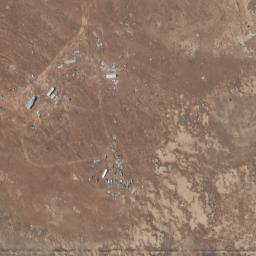

In [28]:
from fastai.vision import *

img = open_image(csv_data['file_save'][0])
img

In [29]:
# View some image statistics

img.data, img.shape, img.size

(tensor([[[0.5412, 0.5373, 0.5373,  ..., 0.5333, 0.5255, 0.5137],
          [0.5294, 0.5294, 0.5294,  ..., 0.5294, 0.5294, 0.5216],
          [0.5176, 0.5216, 0.5255,  ..., 0.5373, 0.5451, 0.5373],
          ...,
          [0.5059, 0.5373, 0.5686,  ..., 0.6588, 0.6745, 0.6980],
          [0.4824, 0.4980, 0.5176,  ..., 0.5804, 0.6196, 0.6627],
          [0.5098, 0.5020, 0.5020,  ..., 0.6392, 0.6431, 0.6667]],
 
         [[0.4275, 0.4235, 0.4235,  ..., 0.4431, 0.4353, 0.4235],
          [0.4157, 0.4157, 0.4157,  ..., 0.4392, 0.4392, 0.4314],
          [0.4039, 0.4078, 0.4118,  ..., 0.4471, 0.4549, 0.4471],
          ...,
          [0.4353, 0.4667, 0.4980,  ..., 0.5843, 0.6000, 0.6235],
          [0.4118, 0.4275, 0.4471,  ..., 0.5059, 0.5451, 0.5882],
          [0.4392, 0.4314, 0.4314,  ..., 0.5647, 0.5686, 0.5922]],
 
         [[0.3725, 0.3686, 0.3686,  ..., 0.3804, 0.3725, 0.3608],
          [0.3608, 0.3608, 0.3608,  ..., 0.3765, 0.3765, 0.3686],
          [0.3490, 0.3529, 0.3569,  ...,